In [13]:
source("qa_plot_functions.R")
library(reshape2)
library(dplyr)

## Download the pheno data to get ratings and other relevant info

### Lets get the pheno file directly from the Internets!

In [14]:
pheno_df<-read.csv("http://s3.amazonaws.com/fcp-indi-new/data/Projects/ABIDE_Initiative/Phenotypic_V1_0b_preprocessed1.csv")

### Conform the names of the raters and their ratings


In [15]:
#conform the names of the raters and their ratings
rater_cols <- setdiff(grep("*rater_", names(pheno_df)),grep("*notes_rater", names(pheno_df)))

# reduce to the columns of interest
pheno_df=pheno_df[c("SUB_ID","SITE_ID",names(pheno_df)[rater_cols],"SUB_IN_SMP")]

# rename SUB_IN_SMP to rater #4
names(pheno_df)[1]="Participant"
names(pheno_df)[8]="qc_rater_4"

# lets be really conservative and make all "maybe" fail
pheno_df[pheno_df=="maybe"]<-"fail"

# rater 4 used 0s and 1s instead of OK and fail, rename them
pheno_df$qc_rater_4=factor(pheno_df$qc_rater_4,levels=c(0,1),labels=c("fail","OK"))

# lets code all missing values as NA, so that they can be easily ignored in future processing
pheno_df[pheno_df==""]<-NA

head(pheno_df)

,Participant,SITE_ID,qc_rater_1,qc_anat_rater_2,qc_func_rater_2,qc_anat_rater_3,qc_func_rater_3,qc_rater_4
1,50002,PITT,fail,OK,fail,OK,fail,OK
2,50003,PITT,OK,OK,OK,OK,OK,OK
3,50004,PITT,OK,OK,OK,OK,OK,OK
4,50005,PITT,OK,OK,fail,OK,OK,fail
5,50006,PITT,OK,OK,fail,OK,OK,OK
6,50007,PITT,OK,OK,fail,OK,OK,OK


### Calculate consensus ratings for the anatomical data

In [16]:
pheno_df$qc_anat<-apply(pheno_df[,c(3,4,6,8)],1, function(x) sum(x=="OK", na.rm=T))
pheno_df$qc_anat<-(pheno_df$qc_anat > 2) + 1
pheno_df$qc_anat<-factor(pheno_df$qc_anat, levels=c(1,2), labels=c("Fail", "OK"))

### Calculate consensus ratings for the functional data

In [17]:
pheno_df$qc_func<-apply(pheno_df[,c(3,5,7,8)],1, function(x) sum(x=="OK", na.rm=T))
pheno_df$qc_func<-(pheno_df$qc_func > 2) + 1
pheno_df$qc_func<-factor(pheno_df$qc_func, levels=c(1,2), labels=c("Fail", "OK"))

## Now lets process the ABIDE Anatomical QAP measures

### Read in the QAP measures, reduce to only the columns of interest, and format for later processing

In [67]:
abide_anat_spat_df<-read.csv("2016_05_ABIDE_qap_anatomical_spatial.csv")

abide_anat_spat_df=merge(abide_anat_spat_df, pheno_df[c('Participant','qc_anat')], by='Participant')

id.vars=c('Participant','Site','Session','Series','qc_anat')
measure.vars=c('CNR','Cortical.Contrast','EFC','FBER','FWHM','Qi1','SNR')
abide_anat_spat_df=abide_anat_spat_df[c(id.vars,measure.vars)]


abide_anat_spat_df=melt(abide_anat_spat_df,
                        id.vars=id.vars,
                        measure.vars=measure.vars,
                        variable.name="Measure")

head(abide_anat_spat_df)

,Participant,Site,Session,Series,qc_anat,Measure,value
1,50002,Pitt,session_1,anat_1,OK,CNR,11.7376361241
2,50003,Pitt,session_1,anat_1,OK,CNR,9.3071467169
3,50004,Pitt,session_1,anat_1,OK,CNR,12.1887839262
4,50005,Pitt,session_1,anat_1,OK,CNR,12.4612905509
5,50006,Pitt,session_1,anat_1,OK,CNR,13.1485533783
6,50007,Pitt,session_1,anat_1,OK,CNR,9.4432486559


### Prepare for plotting by removing outliers

In [68]:
df <- subset(abide_anat_spat_df)
df <- ddply(df, .(Measure), function(x) {
  x <- x[!is.na(x$value),]
  inds <- get_outlier_inds(x$value)
  x[!inds,]
})

ERROR: Error in eval(expr, envir, enclos): could not find function "ddply"


In [20]:
library(grid)
library(gridExtra)



Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



In [118]:
library(repr)
options(repr.plot.width=7, repr.plot.height=3)

       2%       98% 
 5.255683 18.078164 
[1] "CNR, 1, 1, 1"
       2%       98% 
0.2398590 0.4317548 
[1] "Cortical.Contrast, 2, 1, 2"
       2%       98% 
0.3484598 0.5345501 
[1] "EFC, 3, 1, 3"
       2%       98% 
 119.1084 1315.2591 
[1] "FBER, 4, 1, 4"
      2%      98% 
2.594859 5.196846 
[1] "FWHM, 5, 1, 5"
          2%          98% 
6.894695e-05 3.546160e-01 
[1] "Qi1, 6, 1, 6"
      2%      98% 
12.19066 36.22605 
[1] "SNR, 7, 1, 7"


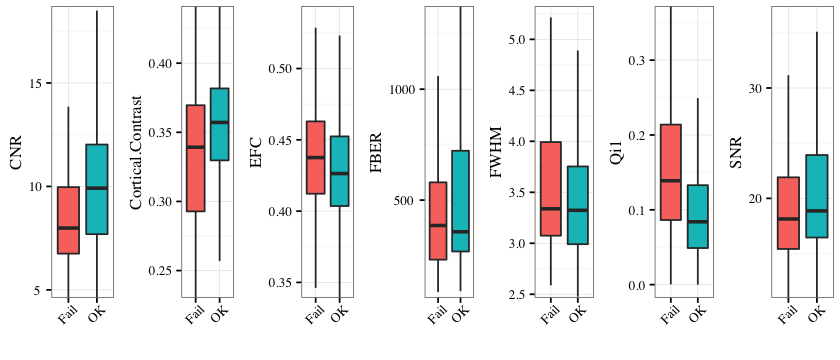

In [119]:
grid.newpage()
ncol=7
nrow=1
pushViewport(viewport(layout = grid.layout(nrow, ncol)))
vplayout <- function(x, y) viewport(layout.pos.row = x, layout.pos.col = y)
#print(a, vp = vplayout(1, 1:2))  # key is to define vplayout
#print(b, vp = vplayout(2, 1))
#print(c, vp = vplayout(2, 2))

for (i in seq(1,length(measure.vars))){
  x=ceiling(i/ncol)
  y=((i-1) %% ncol)+1
  m=measure.vars[i]
  sdf<-subset(df,Measure==m)
  rating.means <- with(sdf, tapply(value, qc_anat, mean))
  rating.sds   <- with(sdf, tapply(value, qc_anat, sd))
  rating.ranges<- with(sdf, quantile(value, probs = c(0.02,.98)))  #sort(rating.means) + (rating.sds[order(rating.means)] * c(-1,1))
    print(rating.ranges)
  p <- ggplot(sdf, aes(x=as.factor(qc_anat), y=value, fill=as.factor(qc_anat))) + 
    #geom_violin(trim = TRUE) + 
    geom_boxplot(outlier.shape = NA,width=1) + 
    theme_bw() +
    theme(legend.position = "none",
          axis.text.x = element_text(family = "Times", face = "plain",size=8, angle=45, hjust=0.75),
          axis.text.y = element_text(family = "Times", face = "plain",size=8, angle=0, hjust=0.75),
          axis.title.y = element_text(family = "Times", face = "plain", size=10, angle=90, vjust=0.9),
          plot.margin = unit(c(.25, .25, 0.25, .25), "lines")) +
    xlab("")+
    ylab(m)+

    #geom_bar(stat="identity") + 
    #stat_summary(fun.y="mean", geom="bar") + 
#    facet_grid(measure ~ ., scale="free_y") +
    coord_cartesian(ylim=rating.ranges)
    #ylab(as.character(sdf$measure[1])) +
    #xlab("") + 
    #theme_bw() #+ 
    #theme(panel.border=element_blank()) +
    #theme(axis.line=element_line(), axis.line.y=element_blank()) +
    #theme(panel.grid.major.x= element_blank()) + 
    #theme(panel.grid.minor.x= element_blank()) + 
    #theme(panel.grid.major.y= element_line(color="grey50")) + 
    #theme(panel.grid.minor.y= element_blank()) + 
    #theme(axis.title.x      = element_blank()) +  
    #theme(axis.title.y      = element_text(family = "Century Gothic", face = "plain", 
    #                                       size=18, angle=90, vjust=0.9)) +  
    #theme(axis.text.x       = element_blank()) +
    #theme(axis.text.y       = element_text(family = "Times", face = "plain", 
    #                                       size=16, angle=0, hjust=0.75)) + 
    #theme(axis.ticks.y = element_line(color="grey50")) + 
    #theme(axis.ticks.length = unit(.15, "lines")) + 
    #theme(axis.ticks.margin = unit(.3, "lines")) + 
    #theme(axis.ticks.x      = element_blank()) +
    #theme(plot.margin       = unit(c(1, 1, 0.25, 1), "lines")) +
    #theme(legend.position   = "none")
   print(sprintf("%s, %d, %d, %d",m,i,x,y))
   print(p, vp = vplayout(x, y))
}

In [ ]:
grid.arrange(pp, ncol = 2, main = "Main title")

In [ ]:
plot(p[[1[]])

In [ ]:
rm(list="p")

In [32]:
ceiling(3/2)


[1] 2

In [89]:
??precentiles

No vignettes or demos or help files found with alias or concept or
title matching ‘precentiles’ using fuzzy matching.